#Import

In [ ]:
#!virtualenv -p python3 virtualenvironment
#!source virtualenvironment/bin/activate
!pip install ta

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [ ]:
from sklearn.model_selection import train_test_split # for the initial split to a train set and a untouched test set 
from sklearn.model_selection import TimeSeriesSplit # for roll forward cross vallidation
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

In [ ]:
import graphviz
from textblob import TextBlob
import re
from ta import add_all_ta_features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.gaussian_process.kernels import RBF

#READ DATA

In [ ]:
df=pd.read_csv("/content/GBPNZD_Candlestick_1_D_BID_13.04.2009-13.04.2021.csv", index_col=0, parse_dates=True)

In [ ]:
df.head()

,Open,High,Low,Close,Volume
Local time,,,,,
2009-12-04 04:00:00-07:00,2.50525,2.50525,2.50525,2.50525,0.0000
2009-04-13 04:00:00-07:00,2.49060,2.52337,2.48594,2.50298,21482.2000
2009-04-14 04:00:00-07:00,2.50208,2.55896,2.50144,2.55195,21510.0001
2009-04-15 04:00:00-07:00,2.55232,2.60876,2.55193,2.57813,21560.1999
2009-04-16 04:00:00-07:00,2.57827,2.63153,2.57360,2.60194,21566.3999


In [ ]:
df=df.dropna()
df.shape

(4385, 5)

In [ ]:
df = df[df.Volume != 0]
df.shape

(3125, 5)

#Preprocess


##Feature engineering

In [ ]:
from ta.trend import EMAIndicator as EMA
from ta.trend import ADXIndicator as ADX
from ta.trend import CCIIndicator as CCI
from ta.trend import MACD 
from ta.trend import IchimokuIndicator as ichimoku
from ta.trend import PSARIndicator as PSAR
from ta.momentum import RSIIndicator as RSI
from ta.momentum import StochasticOscillator as oscillator
from ta.momentum import KAMAIndicator as KAMA
from ta.momentum import PercentagePriceOscillator as PPO
from ta.momentum import PercentageVolumeOscillator as PVO
from ta.momentum import StochRSIIndicator as stochrsi
from ta.momentum import TSIIndicator as TSI
from ta.momentum import UltimateOscillator as Uoscillator
from ta.momentum import WilliamsRIndicator as williamsR
from ta.momentum import ROCIndicator as ROC
from ta.volume import OnBalanceVolumeIndicator as OBV
from ta.volume import AccDistIndexIndicator as ADI
from ta.volume import ChaikinMoneyFlowIndicator as CMF
from ta.volume import EaseOfMovementIndicator as EMV
from ta.volume import ForceIndexIndicator as FI 
from ta.volume import MFIIndicator as MFI
from ta.volume import NegativeVolumeIndexIndicator as NVI
from ta.volume import VolumePriceTrendIndicator as VPT
from ta.volume import VolumeWeightedAveragePrice as VWAP
from ta.volatility import AverageTrueRange as ATR
from ta.volatility import DonchianChannel as donchian
from ta.volatility import KeltnerChannel as keltner
from ta.volatility import UlcerIndex as ULI
from ta.volatility import BollingerBands as blgband

def trend(close,next,percent):
  dff = []
  for i in range(len(close)):
    if ( abs(next[i]-close[i])/close[i] < percent/100 ): # next = close
      dff.append(0)
    else:
      if ( next[i] - close[i] < 0  ): # next < close
        dff.append(2)
      else:
        #if ( next[i] - close[i] > 0 ): # next > close
        dff.append(1)
  #dff.append(0)
  return dff
def trend2(close,high,low):
  dff=[]
  for i in range(len(close)):
    if (low[i] - close[i] > 0):
      dff.append(1)
    else:
      if (high[i] - close[i] < 0):
        dff.append(2)
      else:
        dff.append(0)
  return dff

In [ ]:
ema_short_period=10
ema_long_period=30
rsi_period=14

In [ ]:
#IndicatorsFeatures

#Trend
df["ema_short"]= EMA(df["Close"],window = ema_short_period).ema_indicator()
df["ema_long"]= EMA(df["Close"],window = ema_long_period).ema_indicator()
df["adx"]= ADX(df["High"],df["Low"],df["Close"]).adx()
df["cci"] = CCI(df["High"],df["Low"],df["Close"], ).cci()
df["macd"] = MACD(df["Close"],).macd()
df["ichimoku_a"] = ichimoku(df["High"],df["Low"]).ichimoku_a()
df["ichimoku_b"] = ichimoku(df["High"],df["Low"]).ichimoku_b()
df["ichimoku_base_line"] = ichimoku(df["High"],df["Low"]).ichimoku_base_line()
df["ichimoku_conversion_line"] = ichimoku(df["High"],df["Low"]).ichimoku_conversion_line()
df["psar"] = PSAR(df["High"],df["Low"],df["Close"]).psar()
#Momentum
df["kama"] = KAMA(df["Close"]).kama()
df["PPO"] = PPO(df["Close"]).ppo()
df["PVO"] = PVO(df["Volume"]).pvo()
df["oscillator"] = oscillator(df["High"],df["Low"],df["Close"]).stoch()
df["stochrsi"] = stochrsi(df["Close"]).stochrsi()
df["stochrsi_d"] = stochrsi(df["Close"]).stochrsi_d()
df["stochrsi_k"] = stochrsi(df["Close"]).stochrsi_k()
df["tsi"] = TSI(df["Close"]).tsi()
df["uoscillator"] = Uoscillator(df["High"],df["Low"],df["Close"]).ultimate_oscillator()
df["williamR"] = williamsR(df["High"],df["Low"],df["Close"]).williams_r()
df["rsi"]= RSI(df["Close"],window = rsi_period).rsi()
#Volume
df['obv'] = OBV(df["Close"],df["Volume"]).on_balance_volume()
df["adi"] = ADI(df["High"],df["Low"],df["Close"],df["Volume"]).acc_dist_index()
df["cmf"] = CMF(df["High"],df["Low"],df["Close"],df["Volume"]).chaikin_money_flow()
df["emv"] = EMV(df["High"],df["Low"],df["Volume"]).ease_of_movement() 
df["fi"] = FI(df["Close"],df["Volume"]).force_index()
df["mfi"] = MFI(df["High"],df["Low"],df["Close"],df["Volume"]).money_flow_index()
df["nvi"] = NVI(df["Close"],df["Volume"]).negative_volume_index()
df["vpt"] = VPT(df["Close"],df["Volume"]).volume_price_trend()
df["vwap"] = VWAP(df["High"],df["Low"],df["Close"],df["Volume"]).volume_weighted_average_price()
#Volatility
df["atr"] = ATR(df["High"],df["Low"],df["Close"],).average_true_range()
df["donchian_hband"] = donchian(df["High"],df["Low"],df["Close"],).donchian_channel_hband()
df["donchian_lband"] = donchian(df["High"],df["Low"],df["Close"],).donchian_channel_lband()
df["donchian_mband"] = donchian(df["High"],df["Low"],df["Close"],).donchian_channel_mband()
df["donchian_pband"] = donchian(df["High"],df["Low"],df["Close"],).donchian_channel_pband()
df["donchian_wband"] = donchian(df["High"],df["Low"],df["Close"],).donchian_channel_wband()
df["keltner_hband"] = keltner(df["High"],df["Low"],df["Close"]).keltner_channel_hband()
df["keltner_mband"] = keltner(df["High"],df["Low"],df["Close"]).keltner_channel_mband()
df["keltner_lband"] = keltner(df["High"],df["Low"],df["Close"]).keltner_channel_lband()
df["keltner_pband"] = keltner(df["High"],df["Low"],df["Close"]).keltner_channel_pband()
df["keltner_wband"] = keltner(df["High"],df["Low"],df["Close"]).keltner_channel_wband()
df["uli"] = ULI(df["Close"]).ulcer_index()
df["bolingersband_mavg"] = blgband(df["Close"]).bollinger_mavg()
df["bolingersband_pband"] = blgband(df["Close"]).bollinger_pband()
df["bolingersband_wband"] = blgband(df["Close"]).bollinger_wband()
df["bolingersband_lband"] = blgband(df["Close"]).bollinger_lband()
df["bolingersband_hband"] = blgband(df["Close"]).bollinger_hband()

#Labels
#df["Trend1day"] = trend(df["Close"],df.Close.shift(-1),0.1)
df["Trend7day"] = trend(df["Close"],df.Close.shift(-7),0.1)
#df["Trend7day"] = trend2(df["Close"],df.High.shift(-7),df.Low.shift(-7))
df.shape

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


(3125, 53)

In [ ]:
df.dropna(inplace=True)
df.shape
#df.sample(5)

(3088, 53)

In [ ]:
#num_field = [col for col in df.columns]
num_field = ['Trend7day']
print(num_field)

['Trend7day']


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


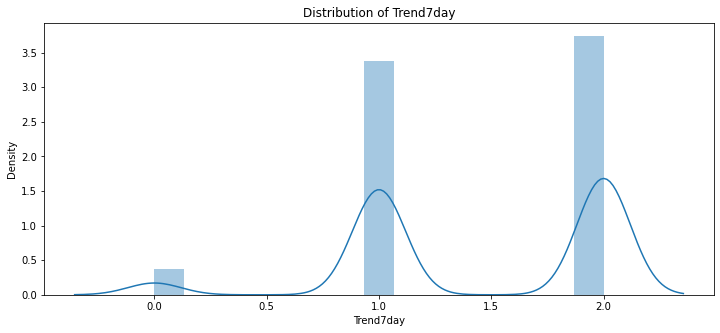

In [ ]:
import seaborn as sns
num_field = ['Trend7day']
#print(num_field)
for field in num_field:
    try:
        plt.figure(figsize=(12,5))
        plt.title("Distribution of " + field)
        ax = sns.distplot(df[field])
    except:
        plt.figure(figsize=(12,5))
        plt.title("Distribution of "+ field)
        ax = sns.distplot(df[field], kde=False)

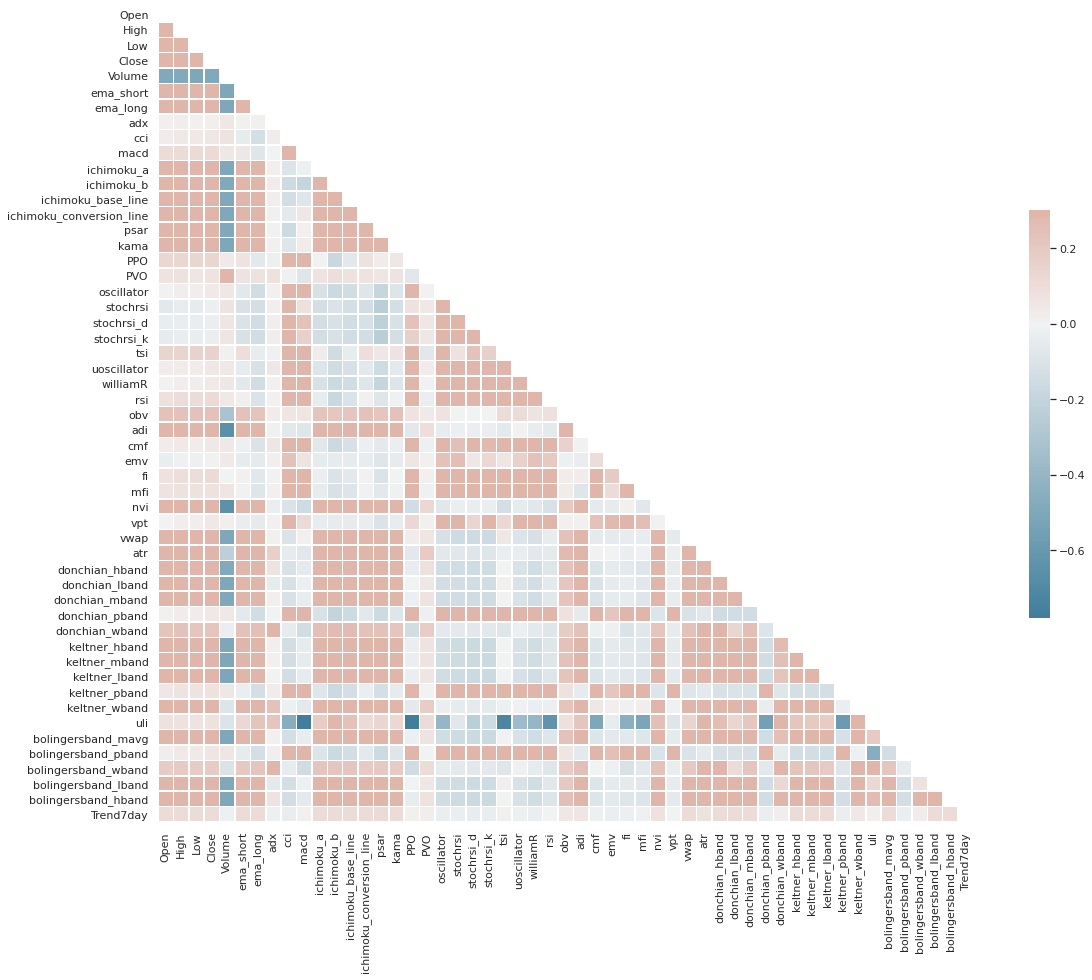

In [ ]:
#uniform_data = df.corr()
#ax = sns.heatmap(uniform_data)
sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##Normalize

In [ ]:
x= df.iloc[:,0:52]
y= df['Trend7day']
sc=StandardScaler(copy=True, with_mean=True, with_std=True)
x_normal =sc.fit_transform(x)
x_train_df , x_test_df, y_train_df, y_test_df = train_test_split(x_normal,y,test_size=0.2,random_state=0)

In [ ]:
print(x_train_df)

[[-0.60561603 -0.63834325 -0.58282318 ...  0.14182749 -0.49061177
  -0.43034958]
 [-0.2407069  -0.23026972 -0.19029079 ... -0.83938552 -0.28963507
  -0.49321966]
 [-0.58387865 -0.62650141 -0.59067125 ... -0.62259982 -0.58936898
  -0.71639376]
 ...
 [ 2.06573679  1.98991841  1.99243889 ...  1.37585547  2.32748829
   2.62606912]
 [-0.54636107 -0.56146528 -0.52840129 ... -0.4065997  -0.34693583
  -0.43590442]
 [ 0.05385677  0.03939839  0.07216941 ... -1.35455103  0.27181539
  -0.11025307]]


##PCA

In [ ]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=25)
#x_train_df = pca.fit_transform(x_train_df)
#x_test_df = pca.transform(x_test_df)

In [ ]:
#information_gain_ratio = pca.explained_variance_ratio_
#print(information_gain_ratio)

In [ ]:
#print(sum(information_gain_ratio))

##NCA

In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
nca = NeighborhoodComponentsAnalysis(n_components=25)
x_train_df = nca.fit_transform(x_train_df,y_train_df)
x_test_df = nca.transform(x_test_df)

#MODEL

##RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
X_train = x_train_df
y_train = y_train_df
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf.score(x_test_df,y_test_df)

0.8220064724919094

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_df, clf.predict(x_test_df))
print(cm)

[[  2  19  11]
 [  1 345  21]
 [  0  58 161]]


In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=df.iloc[:,0:52].columns).sort_values(ascending=False)

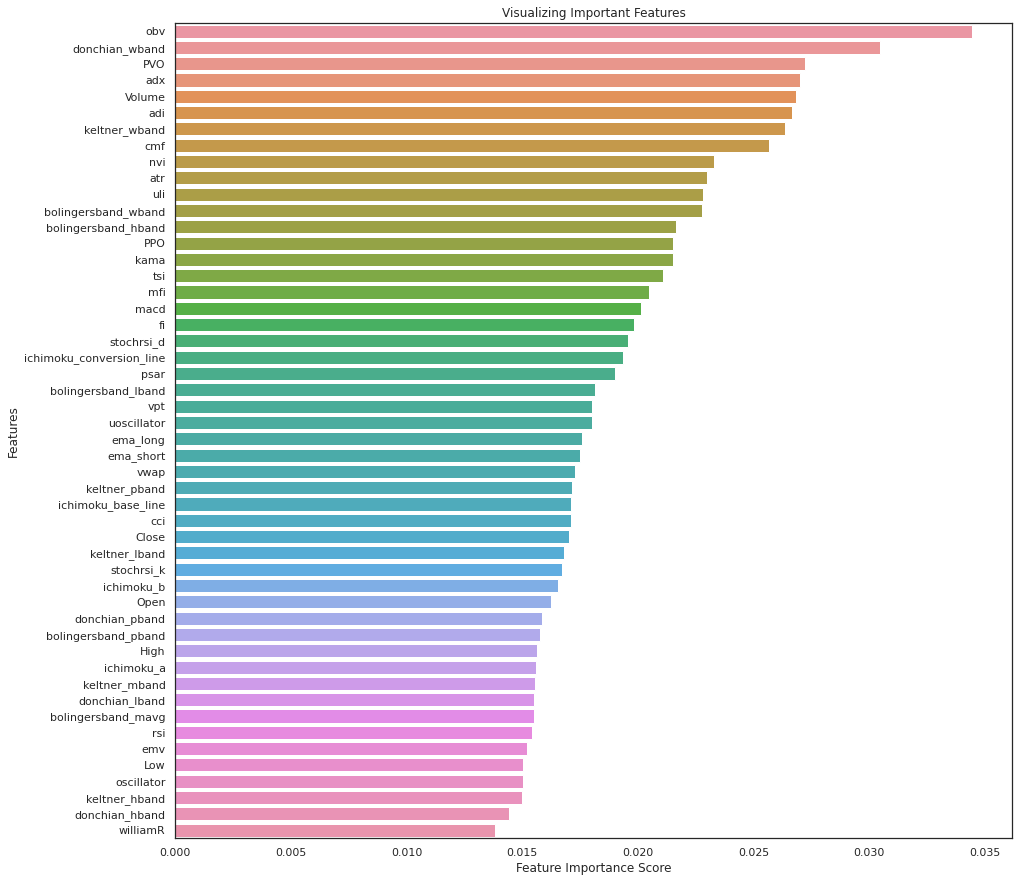

In [ ]:
import seaborn as sns
%matplotlib inline
# Creating a bar plot
plt.figure(figsize = (15, 15))
sns.barplot(x=feature_imp.head(50), y=feature_imp.head(50).index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

##XGB

In [ ]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(x_train_df, y_train_df)
#y_pred = xgbc.predict(x_train_df)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",xgbc.score(x_test_df, y_test_df))

Accuracy: 0.6954177897574124


In [ ]:
cm = confusion_matrix(y_test_df, xgbc.predict(x_test_df))
print(cm)

[[  1  18  19]
 [  2 128  35]
 [  2  37 129]]


##SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#for i in sl:
model = SVC()
model.fit(x_train_df,y_train_df)
z = accuracy_score(y_test_df, model.predict(x_test_df))
print(". Model score: ",z)

. Model score:  0.6495956873315364


In [ ]:
cm = confusion_matrix(y_test_df, model.predict(x_test_df))
print(cm)

[[  0  17  21]
 [  0 117  48]
 [  0  44 124]]


##LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(x_train_df, y_train_df)
z = accuracy_score(y_test_df, lgbm.predict(x_test_df))
print(". Model score: ",z)

#print("Accuracy:",lgbm.score(x_test_df, y_test_df))

. Model score:  0.7789757412398922


In [ ]:
cm = confusion_matrix(y_test_df, lgbm.predict(x_test_df))
print(cm)

[[  1  18  19]
 [  5 143  17]
 [  5  18 145]]


In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
nca = NeighborhoodComponentsAnalysis()
X_train, y_train = x_train_df, y_train_df
nca.fit(X_train,y_train)

NeighborhoodComponentsAnalysis(callback=None, init='auto', max_iter=50,
                               n_components=None, random_state=None, tol=1e-05,
                               verbose=0, warm_start=False)

In [ ]:
X_test,y_test = x_test_df ,y_test_df
lgbm = LGBMClassifier()
lgbm.fit( nca.transform(X_train), y_train)
z = accuracy_score(y_test, lgbm.predict(nca.transform(X_test)))
print(". Model score: ",z)

. Model score:  0.7547169811320755


##Catboost

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat.fit(x_train_df, y_train_df)

Learning rate set to 0.08073
0:	learn: 1.0764249	total: 86.7ms	remaining: 1m 26s
1:	learn: 1.0540048	total: 115ms	remaining: 57.6s
2:	learn: 1.0373682	total: 143ms	remaining: 47.5s
3:	learn: 1.0204033	total: 174ms	remaining: 43.3s
4:	learn: 1.0051028	total: 213ms	remaining: 42.4s
5:	learn: 0.9901231	total: 243ms	remaining: 40.2s
6:	learn: 0.9773996	total: 271ms	remaining: 38.5s
7:	learn: 0.9648513	total: 302ms	remaining: 37.4s
8:	learn: 0.9544005	total: 331ms	remaining: 36.4s
9:	learn: 0.9400627	total: 360ms	remaining: 35.6s
10:	learn: 0.9298303	total: 392ms	remaining: 35.2s
11:	learn: 0.9204650	total: 423ms	remaining: 34.8s
12:	learn: 0.9121404	total: 452ms	remaining: 34.3s
13:	learn: 0.9051447	total: 480ms	remaining: 33.8s
14:	learn: 0.8989389	total: 514ms	remaining: 33.8s
15:	learn: 0.8902560	total: 545ms	remaining: 33.5s
16:	learn: 0.8831784	total: 574ms	remaining: 33.2s
17:	learn: 0.8762808	total: 603ms	remaining: 32.9s
18:	learn: 0.8717169	total: 635ms	remaining: 32.8s
19:	learn:

In [ ]:
z = accuracy_score(y_test_df, cat.predict(x_test_df))
print(". Model score: ",z)

. Model score:  0.7601078167115903


In [ ]:
cm = confusion_matrix(y_test_df, cat.predict(x_test_df))
print(cm)

[[  3  17  18]
 [  3 142  20]
 [  5  26 137]]


##ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(x_train_df, y_train_df)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [ ]:
z = accuracy_score(y_test_df, ada.predict(x_test_df))
print(". Model score: ",z)

. Model score:  0.628032345013477


In [ ]:
cm = confusion_matrix(y_test_df, cat.predict(x_test_df))
print(cm)

[[  3  17  18]
 [  3 142  20]
 [  5  26 137]]


#EXam


In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis
n_components=25
pca = PCA(n_components=n_components)
nca = NeighborhoodComponentsAnalysis(n_components=n_components)

In [ ]:
x_train_pca = nca.fit_transform(x_train_df,y_train_df)
x_test_pca = nca.transform(x_test_df)

#x_train_pca = pca.fit_transform(x_train_df)
#x_test_pca = pca.transform(x_test_df)

In [ ]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(x_train_pca, y_train_df)
z1 = xgbc.score(x_test_pca, y_test_df)
print("Accuracy XGBoost:",z1)

Accuracy XGBoost: 0.6549865229110512


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(x_train_pca, y_train_df)
z2 = accuracy_score(y_test_df, ada.predict(x_test_pca))
print("Accuracy AdaBoost: ",z2)

Accuracy AdaBoost:  0.5795148247978437


In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(silent = True)
cat.fit(x_train_pca, y_train_df,)
z3 = accuracy_score(y_test_df, cat.predict(x_test_pca))
print("Accuracy CatBoost: ",z3)

Accuracy CatBoost:  0.7628032345013477


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train_pca, y_train_df,)
z4 = accuracy_score(y_test_df, mlp.predict(x_test_pca))
print("Accuracy mlp: ",z4)

Accuracy mlp:  0.6630727762803235


In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
gpc = GaussianProcessClassifier()
gpc.fit(x_train_pca, y_train_df,)
z5 = accuracy_score(y_test_df, gpc.predict(x_test_pca))
print("Accuracy gpc: ",z5)

Accuracy gpc:  0.5633423180592992


In [ ]:
print("Accuracy XGBoost:",z1)
print("Accuracy AdaBoost: ",z2)
print("Accuracy CatBoost: ",z3)
print("Accuracy mlp: ",z4)
print("Accuracy gpc: ",z5)

Accuracy XGBoost: 0.6549865229110512
Accuracy AdaBoost:  0.5795148247978437
Accuracy CatBoost:  0.7628032345013477
Accuracy mlp:  0.6630727762803235
Accuracy gpc:  0.5633423180592992


#LOOP

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


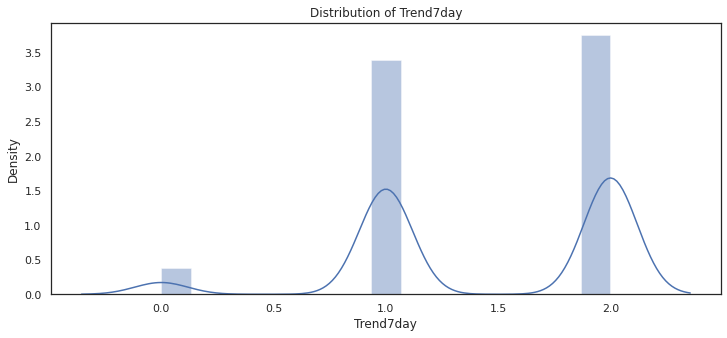

In [ ]:
import seaborn as sns
num_field = ['Trend7day']
#print(num_field)
for field in num_field:
    try:
        plt.figure(figsize=(12,5))
        plt.title("Distribution of " + field)
        ax = sns.distplot(df[field])
    except:
        plt.figure(figsize=(12,5))
        plt.title("Distribution of "+ field)
        ax = sns.distplot(df[field], kde=False)

##NCA

In [ ]:
cat_s = []
mlp_s = []
gpc_s = []
svm_s = []
n = [5,10,15,20,25,30,35,40,45,50]

for i in n:
  n_components=i
  pca = PCA(n_components=n_components)
  nca = NeighborhoodComponentsAnalysis(n_components=n_components)
  
  x_train_pca = nca.fit_transform(x_train_df,y_train_df)
  x_test_pca = nca.transform(x_test_df)

  #xgbc = XGBClassifier(n_estimators=500)
  #xgbc.fit(x_train_pca, y_train_df)
  #z1 = xgbc.score(x_test_pca, y_test_df)

  #ada = AdaBoostClassifier(n_estimators=100, random_state=0)
  #ada.fit(x_train_pca, y_train_df)
  #z2 = accuracy_score(y_test_df, ada.predict(x_test_pca))
  
  cat = CatBoostClassifier(silent = True)
  cat.fit(x_train_pca, y_train_df)
  z3 = accuracy_score(y_test_df, cat.predict(x_test_pca))

  mlp = MLPClassifier()
  mlp.fit(x_train_pca, y_train_df)
  z4 = accuracy_score(y_test_df, mlp.predict(x_test_pca))

 # kernel = 1.0 * RBF(1.0)
  gpc = GaussianProcessClassifier()#kernel=kernel)
  gpc.fit(x_train_pca, y_train_df)
  z5 = accuracy_score(y_test_df, gpc.predict(x_test_pca))

  svm = SVC(decision_function_shape='ovo')
  svm.fit(x_train_pca,y_train_df)
  z6 = accuracy_score(y_test_df, svm.predict(x_test_pca))

  cat_s.append(z3)
  mlp_s.append(z4)
  gpc_s.append(z5)
  svm_s.append(z6) 
  #print("Num of features NCA: ",i)
  #print("Accuracy mlp: ",z4)
  #print("Accuracy CatBoost: ",z3)
  #print("Accuracy gpc: ",z5)
  #print("Accuracy SVM: ",z6)
  data = []
  data.append(cat_s)
  data.append(mlp_s)
  data.append(gpc_s)
  data.append(svm_s)
  NCAR = pd.DataFrame(data=data,index=['cat','mlp','gpc','svm'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


##PCA

In [ ]:
cat_s = []
mlp_s = []
gpc_s = []
svm_s = []
n = [5,10,15,20,25,30,35,40,45,50]

for i in n:
  n_components=i
  pca = PCA(n_components=n_components)
  nca = NeighborhoodComponentsAnalysis(n_components=n_components)
  
  x_train_pca = pca.fit_transform(x_train_df,y_train_df)
  x_test_pca = pca.transform(x_test_df)

  
  #xgbc = XGBClassifier(n_estimators=500)
  #xgbc.fit(x_train_pca, y_train_df)
  #z1 = xgbc.score(x_test_pca, y_test_df)

  #ada = AdaBoostClassifier(n_estimators=100, random_state=0)
  #ada.fit(x_train_pca, y_train_df)
  #z2 = accuracy_score(y_test_df, ada.predict(x_test_pca))
  
  cat = CatBoostClassifier(silent = True)
  cat.fit(x_train_pca, y_train_df,)
  z3 = accuracy_score(y_test_df, cat.predict(x_test_pca))

  mlp = MLPClassifier()
  mlp.fit(x_train_pca, y_train_df,)
  z4 = accuracy_score(y_test_df, mlp.predict(x_test_pca))

  #kernel = 1.0 * RBF(1.0)
  gpc = GaussianProcessClassifier()#kernel=kernel)
  gpc.fit(x_train_pca, y_train_df,)
  z5 = accuracy_score(y_test_df, gpc.predict(x_test_pca))

  svm = SVC(decision_function_shape='ovo')
  svm.fit(x_train_pca,y_train_df)
  z6 = accuracy_score(y_test_df, svm.predict(x_test_pca))

  cat_s.append(z3)
  mlp_s.append(z4)
  gpc_s.append(z5)
  svm_s.append(z6) 

  #print("Num of features PCA: ",i)
  #print("Accuracy mlp: ",z4)
  #print("Accuracy CatBoost: ",z3)
  #print("Accuracy gpc: ",z5)
  #print("Accuracy SVM: ",z6)
data = []
data.append(cat_s)
data.append(mlp_s)
data.append(gpc_s)
data.append(svm_s)
PCAR = pd.DataFrame(data=data,index=['cat','mlp','gpc','svm'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


##Select

In [ ]:
clf=RandomForestClassifier(n_estimators=100)
X_train = x_train_df
y_train = y_train_df
clf.fit(X_train,y_train)
feature_imp = pd.Series(clf.feature_importances_,index=df.iloc[:,0:52].columns).sort_values(ascending=False)

cat_s = []
mlp_s = []
gpc_s = []
svm_s = []
n = [5,10,15,20,25,30,35,40,45,50]
for i in n:

  id = feature_imp[0:i].index
  x= df[id]
  y= df['Trend7day']
  sc=StandardScaler(copy=True, with_mean=True, with_std=True)
  x_normal =sc.fit_transform(x)
  #select
  x_train_pca , x_test_pca, y_train_df, y_test_df = train_test_split(x_normal,y,test_size=0.2,random_state=0)


  n_components=i
  pca = PCA(n_components=n_components)
  nca = NeighborhoodComponentsAnalysis(n_components=n_components)
  

  #nca
  #x_train_pca = nca.fit_transform(x_train_df,y_train_df)
  #x_test_pca = nca.transform(x_test_df)
  #pca
  #x_train_pca = pca.fit_transform(x_train_df,y_train_df)
  #x_test_pca = pca.transform(x_test_df)

  #xgbc = XGBClassifier(n_estimators=500)
  #xgbc.fit(x_train_pca, y_train_df)
  #z1 = xgbc.score(x_test_pca, y_test_df)

  #ada = AdaBoostClassifier(n_estimators=100, random_state=0)
  #ada.fit(x_train_pca, y_train_df)
  #z2 = accuracy_score(y_test_df, ada.predict(x_test_pca))
  
  cat = CatBoostClassifier(silent = True)
  cat.fit(x_train_pca, y_train_df,)
  z3 = accuracy_score(y_test_df, cat.predict(x_test_pca))

  mlp = MLPClassifier()
  mlp.fit(x_train_pca, y_train_df,)
  z4 = accuracy_score(y_test_df, mlp.predict(x_test_pca))

  #kernel = 1.0 * RBF(1.0)
  gpc = GaussianProcessClassifier()#kernel=kernel)
  gpc.fit(x_train_pca, y_train_df)
  z5 = accuracy_score(y_test_df, gpc.predict(x_test_pca))

  svm = SVC(decision_function_shape='ovo')
  svm.fit(x_train_pca,y_train_df)
  z6 = accuracy_score(y_test_df, svm.predict(x_test_pca))

  #xgbc_s.append()
  #ada_s = []
  cat_s.append(z3)
  mlp_s.append(z4)
  gpc_s.append(z5)
  svm_s.append(z6) 

  #print("Num of features PCA: ",i)
  #print("Accuracy XGBoost: ",z1)
  #print("Accuracy AdaBoost: ",z2)
  #print("Accuracy mlp: ",z4)
  #print("Accuracy CatBoost: ",z3)
  #print("Accuracy gpc: ",z5)
  #print("Accuracy SVM: ",z6)
data = []
data.append(cat_s)
data.append(mlp_s)
data.append(gpc_s)
data.append(svm_s)
SelectR = pd.DataFrame(data=data,index=['cat','mlp','gpc','svm'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#Result

In [ ]:
PCAR

,0,1,2,3,4,5,6,7,8,9
cat,0.710356,0.736246,0.776699,0.755663,0.783172,0.766990,0.775081,0.788026,0.771845,0.775081
mlp,0.631068,0.660194,0.707120,0.726537,0.731392,0.752427,0.757282,0.776699,0.750809,0.745955
gpc,0.710356,0.762136,0.797735,0.788026,0.796117,0.797735,0.797735,0.797735,0.797735,0.797735
svm,0.600324,0.610032,0.647249,0.645631,0.652104,0.653722,0.652104,0.652104,0.652104,0.652104


In [ ]:
NCAR

,0,1,2,3,4,5,6,7,8,9
cat,0.760518,0.762136,0.754045,0.739482,0.741100,0.758900,0.752427,0.776699,0.747573,0.733010
mlp,0.639159,0.676375,0.715210,0.682848,0.723301,0.715210,0.681230,0.703883,0.689320,0.726537
gpc,0.588997,0.619741,0.563107,0.517799,0.592233,0.538835,0.542071,0.538835,0.551780,0.556634
svm,0.608414,0.622977,0.608414,0.637540,0.626214,0.634304,0.640777,0.632686,0.634304,0.635922


In [ ]:
SelectR

,0,1,2,3,4,5,6,7,8,9
cat,0.812298,0.807443,0.809061,0.810680,0.818770,0.799353,0.807443,0.804207,0.815534,0.822006
mlp,0.622977,0.682848,0.724919,0.749191,0.747573,0.739482,0.736246,0.737864,0.739482,0.741100
gpc,0.637540,0.728155,0.762136,0.812298,0.820388,0.799353,0.805825,0.807443,0.810680,0.810680
svm,0.613269,0.639159,0.634304,0.700647,0.707120,0.673139,0.669903,0.668285,0.655340,0.658576
